In [1]:
!gdown 1zRHT9eSFUNK6o3AHwQmyAeFzXfEzkEts
!unzip vqa_coco_dataset -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/val2014-resised/COCO_val2014_000000227893.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000227901.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000227952.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000227960.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228013.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228135.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228166.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228306.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228436.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228464.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228506.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228541.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_000000228552.jpg  
  inflating: dataset/val2014-resised/COCO_val2014_00

In [2]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 6.9 MB/s eta 0:00:00


#### Import các thư viện cần thiết

In [3]:
import torch
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import LlavaForConditionalGeneration
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
from transformers import GenerationConfig
from PIL import Image

#### Đọc bộ dữ liệu test

In [4]:
# Load test data
test_data = []
test_set_path = 'dataset/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

#### Khai báo mô hình VLM

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

#### Xây dựng hàm tạo prompt

In [6]:
def create_prompt(question):
    prompt = f"""### INSTRUCTION:
        Your task is to answer the question based on the given image. You can
        only answer 'yes' or 'no'.
        ### USER: <image>
        {question}
        ### ASSISTANT:"""
    return prompt

#### Khai báo các tham số tạo sinh

In [7]:
generation_config = GenerationConfig(
    max_new_tokens=10,
    do_sample=True,
    temperature=0.1,
    top_p=0.95,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token=model.config.pad_token_id,
)

#### Thực hiện dự đoán

You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transformers v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


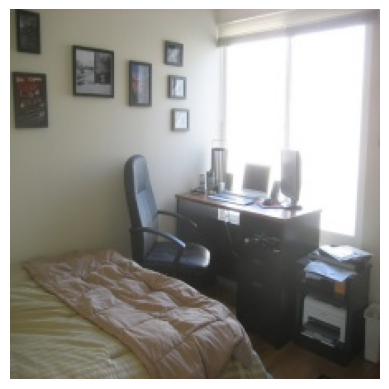

Question: Are there any boxes in the room ?
Label: no
Prediction:  No


In [8]:
idx = 0
question = test_data[idx]['question']
image_name = test_data[idx]['image_path']
image_path = os.path.join('dataset/val2014-resised', image_name)
label = test_data[idx]['answer']
image = Image.open(image_path)

prompt = create_prompt(question)
inputs = processor(prompt,
                   image,
                   padding=True,
                   return_tensors="pt").to(device)
output = model.generate(**inputs,
                        generation_config=generation_config)

generated_text = processor.decode(output[0],
                                  skip_special_tokens=True)
plt.imshow(image)
plt.axis("off")
plt.show()
print(f"Question: {question}")
print(f"Label: {label}")
print(f"Prediction: {generated_text.split('### ASSISTANT:')[-1]}")